#Track popularity Prediction

In [1]:
# Core imports
import kagglehub
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from imblearn.over_sampling import SMOTE  # (Potential future use for imbalance handling)
from imblearn.ensemble import BalancedRandomForestClassifier  # (Currently unused)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

e:\MLOps\MLOps-Spotify\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data from kaggle
data_path=kagglehub.dataset_download("amitanshjoshi/spotify-1million-tracks")
df=pd.read_csv(f"{data_path}/spotify_data.csv")

In [3]:
df.head()

,Unnamed: 0,artist_name,track_name,track_id,popularity,year,genre,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
0,0,Jason Mraz,I Won't Give Up,53QF56cjZA9RTuuMZDrSA6,68,2012,acoustic,0.483,0.303,4,-10.058,1,0.0429,0.6940,0.000000,0.1150,0.139,133.406,240166,3
1,1,Jason Mraz,93 Million Miles,1s8tP3jP4GZcyHDsjvw218,50,2012,acoustic,0.572,0.454,3,-10.286,1,0.0258,0.4770,0.000014,0.0974,0.515,140.182,216387,4
2,2,Joshua Hyslop,Do Not Let Me Go,7BRCa8MPiyuvr2VU3O9W0F,57,2012,acoustic,0.409,0.234,3,-13.711,1,0.0323,0.3380,0.000050,0.0895,0.145,139.832,158960,4
3,3,Boyce Avenue,Fast Car,63wsZUhUZLlh1OsyrZq7sz,58,2012,acoustic,0.392,0.251,10,-9.845,1,0.0363,0.8070,0.000000,0.0797,0.508,204.961,304293,4
4,4,Andrew Belle,Sky's Still Blue,6nXIYClvJAfi6ujLiKqEq8,54,2012,acoustic,0.430,0.791,6,-5.419,0,0.0302,0.0726,0.019300,0.1100,0.217,171.864,244320,4


In [4]:
df.shape

(1159764, 20)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1159764 entries, 0 to 1159763
Data columns (total 20 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   Unnamed: 0        1159764 non-null  int64  
 1   artist_name       1159749 non-null  object 
 2   track_name        1159763 non-null  object 
 3   track_id          1159764 non-null  object 
 4   popularity        1159764 non-null  int64  
 5   year              1159764 non-null  int64  
 6   genre             1159764 non-null  object 
 7   danceability      1159764 non-null  float64
 8   energy            1159764 non-null  float64
 9   key               1159764 non-null  int64  
 10  loudness          1159764 non-null  float64
 11  mode              1159764 non-null  int64  
 12  speechiness       1159764 non-null  float64
 13  acousticness      1159764 non-null  float64
 14  instrumentalness  1159764 non-null  float64
 15  liveness          1159764 non-null  float64
 16  

In [6]:
df.describe().round(3).T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,1159764.0,659061.322,428549.154,0.0,289940.750,579881.500,1031689.250,1473395.000
popularity,1159764.0,18.383,15.886,0.0,5.000,15.000,29.000,100.000
year,1159764.0,2011.955,6.804,2000.0,2006.000,2012.000,2018.000,2023.000
danceability,1159764.0,0.537,0.184,0.0,0.413,0.550,0.677,0.993
energy,1159764.0,0.640,0.271,0.0,0.454,0.694,0.873,1.000
key,1159764.0,5.288,3.555,0.0,2.000,5.000,8.000,11.000
loudness,1159764.0,-8.981,5.682,-58.1,-10.829,-7.450,-5.276,6.172
mode,1159764.0,0.635,0.482,0.0,0.000,1.000,1.000,1.000
speechiness,1159764.0,0.093,0.127,0.0,0.037,0.051,0.089,0.971
acousticness,1159764.0,0.322,0.355,0.0,0.006,0.147,0.640,0.996


In [7]:
df.isna().sum()

Unnamed: 0           0
artist_name         15
track_name           1
track_id             0
popularity           0
year                 0
genre                0
danceability         0
energy               0
key                  0
loudness             0
mode                 0
speechiness          0
acousticness         0
instrumentalness     0
liveness             0
valence              0
tempo                0
duration_ms          0
time_signature       0
dtype: int64

In [3]:
def clean_data(df):
    """Simple and robust data cleaning"""

    df_clean = df.copy()

    # Handle missing values
    df_clean['artist_name'] = df_clean['artist_name'].fillna('Unknown Artist')
    df_clean['track_name'] = df_clean['track_name'].fillna('Unknown Track')

    # Create popularity tiers (70+ = high, 41-69 = medium, 0-40 = low)
    conditions = [
        (df_clean['popularity'] <= 40),
        (df_clean['popularity'] > 40) & (df_clean['popularity'] < 70),
        (df_clean['popularity'] >= 70)
    ]
    choices = ['low', 'medium', 'high']
    df_clean['popularity_tier'] = np.select(conditions, choices, default='medium')

    print("✅ Data cleaning complete")
    print(f"   Low: {(df_clean['popularity_tier'] == 'low').sum():,} songs")
    print(f"   Medium: {(df_clean['popularity_tier'] == 'medium').sum():,} songs") 
    print(f"   High: {(df_clean['popularity_tier'] == 'high').sum():,} songs")

    return df_clean

✅ Data cleaning complete
   Low: 1,036,907 songs
   Medium: 119,411 songs
   High: 3,446 songs


array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'popularity'}>,
        <Axes: title={'center': 'year'}>,
        <Axes: title={'center': 'danceability'}>],
       [<Axes: title={'center': 'energy'}>,
        <Axes: title={'center': 'key'}>,
        <Axes: title={'center': 'loudness'}>,
        <Axes: title={'center': 'mode'}>],
       [<Axes: title={'center': 'speechiness'}>,
        <Axes: title={'center': 'acousticness'}>,
        <Axes: title={'center': 'instrumentalness'}>,
        <Axes: title={'center': 'liveness'}>],
       [<Axes: title={'center': 'valence'}>,
        <Axes: title={'center': 'tempo'}>,
        <Axes: title={'center': 'duration_ms'}>,
        <Axes: title={'center': 'time_signature'}>]], dtype=object)

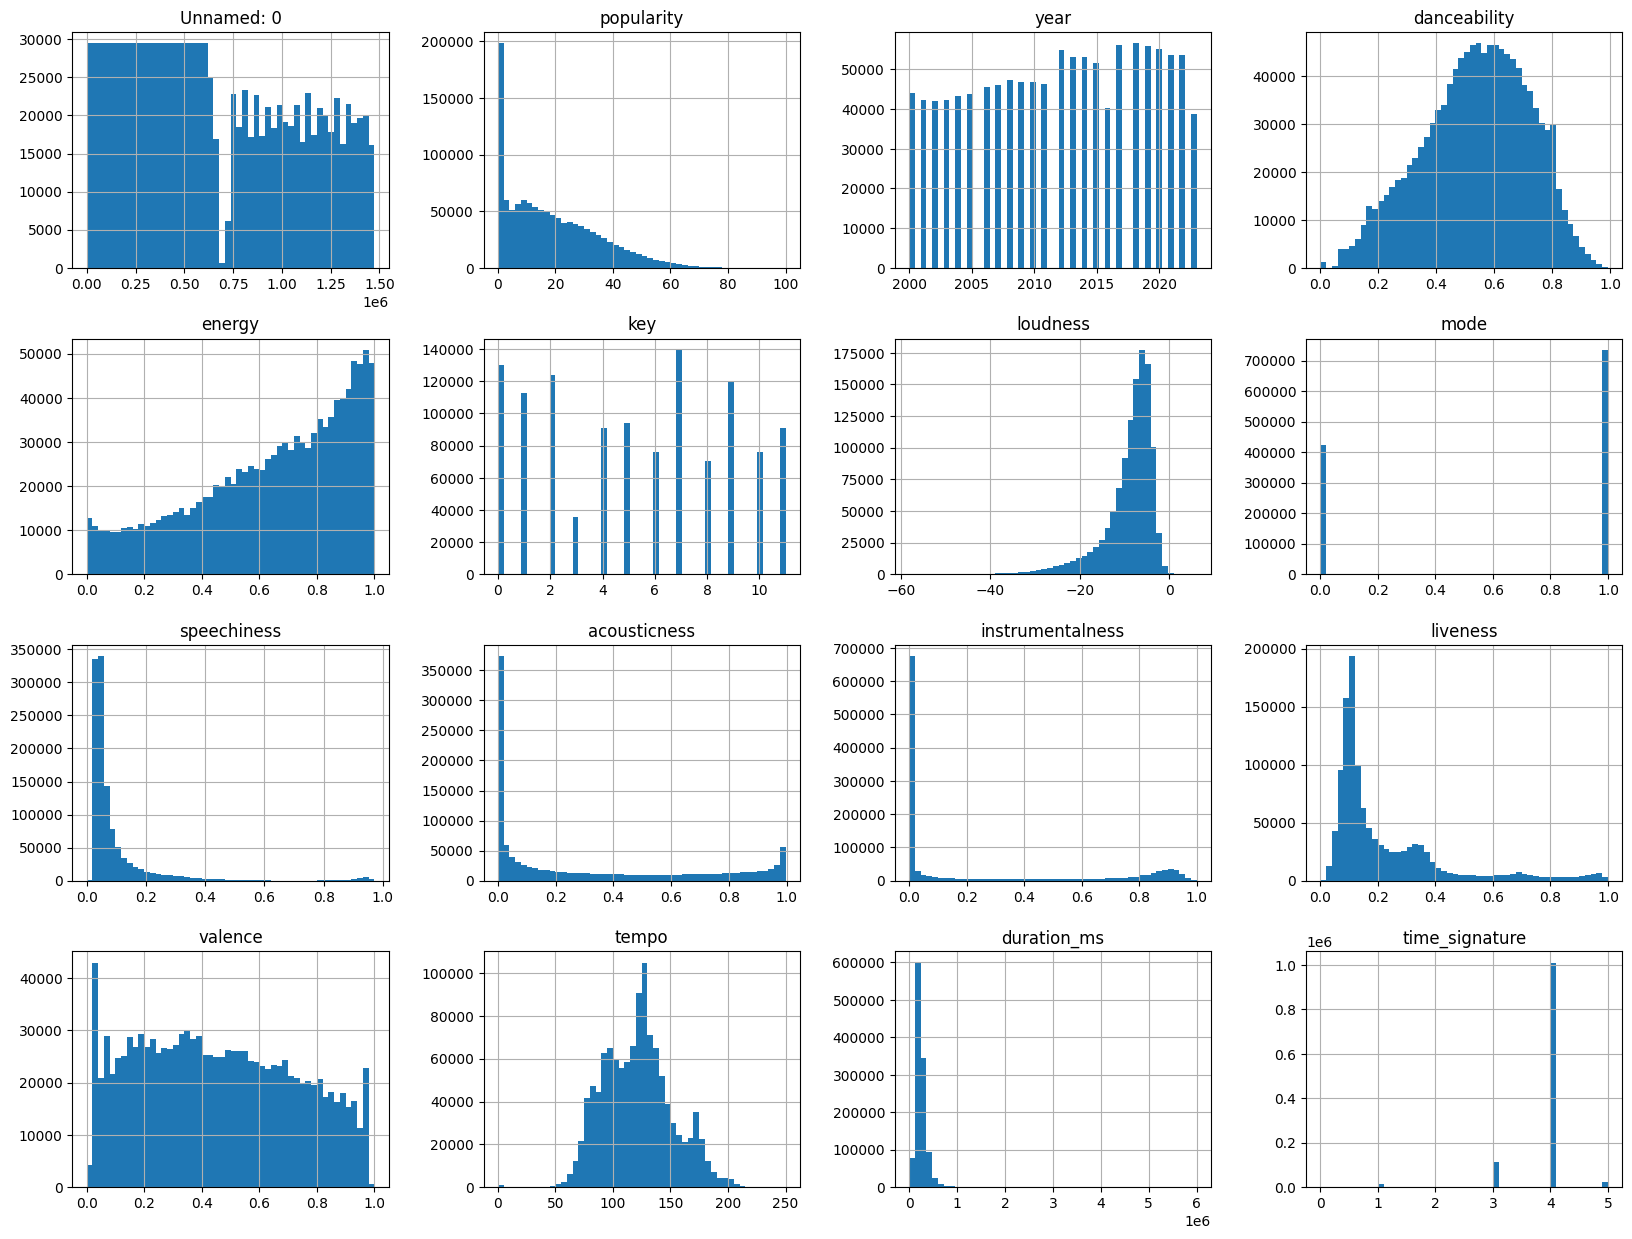

In [5]:
df_clean = clean_data(df)
df_clean.hist(bins=50, figsize=(20, 15))

In [9]:
def engineer_features(df):
    """Create powerful features while preserving interpretability"""
    print("\n🎯 ENGINEERING FEATURES...")

    # Start with clean data
    X = df.copy()

    # Drop unnecessary columns
    cols_to_drop = ['Unnamed: 0', 'track_id', 'popularity', 'popularity_tier']
    X = X.drop([col for col in cols_to_drop if col in X.columns], axis=1)

    # 1. Convert duration to minutes
    X['duration_minutes'] = X['duration_ms'] / 60000
    X['duration_minutes'] = X['duration_minutes'].round(2)
    X = X.drop('duration_ms', axis=1)

    # 2. Artist features
    print("   Creating artist features...")
    artist_stats = df.groupby('artist_name').agg({
        'popularity': ['mean', 'count', 'max']
    }).round(3)
    artist_stats.columns = ['artist_avg_pop', 'artist_track_count', 'artist_max_pop']
    artist_stats = artist_stats.reset_index()

    X = X.merge(artist_stats, on='artist_name', how='left')

    # Fill missing artist stats
    X['artist_avg_pop'] = X['artist_avg_pop'].fillna(df['popularity'].mean())
    X['artist_track_count'] = X['artist_track_count'].fillna(1)
    X['artist_max_pop'] = X['artist_max_pop'].fillna(df['popularity'].mean())

    # Create numeric artist features
    X['artist_experience'] = np.log1p(X['artist_track_count'])
    # Safely convert artist_avg_pop into tiers while preserving NaNs using nullable Int
    _artist_tier = pd.cut(X['artist_avg_pop'], bins=[0, 30, 60, 100], labels=[0, 1, 2])
    X['artist_tier'] = _artist_tier.cat.codes.replace(-1, pd.NA).astype('Int64')

    # 3. Genre features
    print("   Creating genre features...")
    # Multi-hot encoding for top genres
    all_genres = df['genre'].str.get_dummies(sep=' ')
    top_genres = all_genres.sum().sort_values(ascending=False).head(15).index
    genre_dummies = all_genres[top_genres]
    genre_dummies.columns = [f'genre_{col}' for col in genre_dummies.columns]

    # Genre complexity
    X['num_genres'] = df['genre'].str.split().str.len().fillna(1)
    X['is_multigenre'] = (X['num_genres'] > 1).astype(int)

    # Mainstream indicator
    mainstream_genres = ['pop', 'rock', 'hip', 'rap', 'dance']
    X['has_mainstream_genre'] = df['genre'].apply(
        lambda x: any(genre in str(x).lower() for genre in mainstream_genres)
    ).astype(int)

    # Combine genre features
    X = pd.concat([X, genre_dummies], axis=1)

    # 4. Temporal features
    print("   Creating temporal features...")
    X['years_since_release'] = 2025 - df['year']
    X['is_recent'] = (df['year'] >= 2020).astype(int)
    # Safely convert era into numeric categories with nullable Int
    _era = pd.cut(df['year'], bins=[1999, 2005, 2010, 2015, 2020, 2025], 
                  labels=['2000-2005', '2006-2010', '2011-2015', '2016-2020', '2021-2025'])
    X['era'] = _era.cat.codes.replace(-1, pd.NA).astype('Int64')

    # 5. Audio features
    print("   Creating audio features...")
    # Commercial appeal score
    X['commercial_appeal'] = (
        df['danceability'] * 0.3 +
        df['energy'] * 0.25 +
        (1 - df['acousticness']) * 0.2 +
        df['valence'] * 0.15 +
        ((df['loudness'] + 60) / 60) * 0.1
    ).round(3)

    # Music style indicators
    X['dance_track_potential'] = (df['danceability'] * df['energy']).round(3)
    X['chill_track_potential'] = (df['acousticness'] * (1 - df['energy'])).round(3)

    # Emotional characteristics
    X['happiness_score'] = (df['valence'] * df['energy']).round(3)

    # Duration features
    X['is_radio_friendly'] = ((X['duration_minutes'] >= 2.5) & 
                             (X['duration_minutes'] <= 4.0)).astype(int)

    # Normalized loudness
    X['normalized_loudness'] = ((df['loudness'] + 60) / 60).clip(0, 1).round(3)

    # Tempo category - use nullable Int to avoid conversion errors
    _tempo_cat = pd.cut(df['tempo'], bins=5, labels=[0, 1, 2, 3, 4])
    X['tempo_category'] = _tempo_cat.cat.codes.replace(-1, pd.NA).astype('Int64')

    # 6. Final feature preparation
    print("   Finalizing features...")

    # Separate features from identifiers
    feature_columns = [col for col in X.columns if col not in ['artist_name', 'track_name', 'genre', 'year']]
    X_features = X[feature_columns].copy()
    X_identifiers = X[['artist_name', 'track_name']].copy()

    # Ensure all features are numeric
    for col in X_features.columns:
        if X_features[col].dtype in ['object', 'category']:
            X_features[col] = pd.to_numeric(X_features[col], errors='coerce').fillna(0)

    # Handle any remaining missing values
    for col in X_features.columns:
        if X_features[col].isna().any():
            X_features[col] = X_features[col].fillna(X_features[col].median())

    print(f"✅ Feature engineering complete")
    print(f"   {X_features.shape[1]} numeric features created")
    print(f"   Artist and track names preserved for interpretability")

    return X_features, X_identifiers


In [10]:
def train_model(X_features, X_identifiers, y):
    """Train and evaluate the popularity prediction model"""
    print("\n🚀 TRAINING MODEL...")

    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Split data (maintaining alignment between features and identifiers)
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # Split identifiers for test set
    _, X_test_ids, _, _ = train_test_split(
        X_identifiers, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    print(f"   Training set: {X_train.shape[0]:,} samples")
    print(f"   Test set: {X_test.shape[0]:,} samples")
    print(f"   Features: {X_train.shape[1]}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train Random Forest model
    model = RandomForestClassifier(
        n_estimators=150,
        max_depth=20,
        min_samples_split=10,
        min_samples_leaf=4,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1
    )

    print("   Training in progress...")
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_proba = model.predict_proba(X_test_scaled)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"✅ Model trained successfully!")
    print(f"📊 Test Accuracy: {accuracy:.3f}")

    return model, scaler, label_encoder, X_test, X_test_ids, y_test, y_pred, y_pred_proba


In [11]:
# ===============================
# RESULTS AND VISUALIZATION
# ===============================
def create_results(X_test, X_test_ids, y_test, y_pred, y_pred_proba, label_encoder):
    """Create interpretable results with artist and track names"""

    # Convert predictions back to original labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Create comprehensive results DataFrame
    results_df = X_test_ids.reset_index(drop=True).copy()
    results_df['true_popularity'] = y_test_labels
    results_df['predicted_popularity'] = y_pred_labels
    results_df['prediction_confidence'] = np.max(y_pred_proba, axis=1)

    # Add probability for each class
    for i, class_name in enumerate(label_encoder.classes_):
        results_df[f'prob_{class_name}'] = y_pred_proba[:, i]

    # Add correct/incorrect flag
    results_df['correct_prediction'] = (y_test_labels == y_pred_labels)

    # Sort by confidence for easy review
    results_df = results_df.sort_values('prediction_confidence', ascending=False)

    return results_df

def analyze_results(results_df, y_test, y_pred, label_encoder):
    """Comprehensive results analysis"""
    print("\n📊 RESULTS ANALYSIS")
    print("=" * 50)

    # Overall accuracy
    accuracy = results_df['correct_prediction'].mean()
    print(f"Overall Accuracy: {accuracy:.1%}")

    # Class-wise performance
    print("\n🎯 CLASS-WISE PERFORMANCE:")
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)
    print(classification_report(y_test_labels, y_pred_labels))

    # Business insights
    print("💼 BUSINESS INSIGHTS:")
    high_confidence_hits = results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['prediction_confidence'] > 0.7)
    ]

    potential_hits = results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['true_popularity'] != 'high') &
        (results_df['prediction_confidence'] > 0.6)
    ]

    print(f"   High-confidence hit predictions: {len(high_confidence_hits):,}")
    print(f"   Potential undiscovered hits: {len(potential_hits):,}")
    print(f"   Overall correct predictions: {results_df['correct_prediction'].sum():,}/{len(results_df):,}")

    # Top predictions
    print(f"\n🔝 TOP 10 HIGH-CONFIDENCE PREDICTIONS:")
    top_predictions = results_df[['artist_name', 'track_name', 'true_popularity', 
                                'predicted_popularity', 'prediction_confidence']].head(10)
    print(top_predictions.to_string(index=False))

    return high_confidence_hits, potential_hits

def plot_confusion_matrix(y_test, y_pred, label_encoder):
    """Plot confusion matrix for model evaluation"""
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    cm = confusion_matrix(y_test_labels, y_pred_labels, 
                         labels=label_encoder.classes_)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title('Confusion Matrix - Popularity Prediction')
    plt.ylabel('True Popularity')
    plt.xlabel('Predicted Popularity')
    plt.show()


🎵 SPOTIFY POPULARITY PREDICTION PIPELINE
✅ Data cleaning complete
   Low: 1,036,907 songs
   Medium: 119,411 songs
   High: 3,446 songs

🎯 ENGINEERING FEATURES...
   Creating artist features...
   Creating genre features...
   Creating temporal features...
   Creating audio features...
   Finalizing features...
✅ Feature engineering complete
   46 numeric features created
   Artist and track names preserved for interpretability

🚀 TRAINING MODEL...
   Training set: 927,811 samples
   Test set: 231,953 samples
   Features: 46
   Training in progress...
✅ Model trained successfully!
📊 Test Accuracy: 0.891

📊 RESULTS ANALYSIS
Overall Accuracy: 89.1%

🎯 CLASS-WISE PERFORMANCE:
              precision    recall  f1-score   support

        high       0.20      0.45      0.28       689
         low       0.97      0.91      0.94    207382
      medium       0.48      0.75      0.59     23882

    accuracy                           0.89    231953
   macro avg       0.55      0.70      0.60   

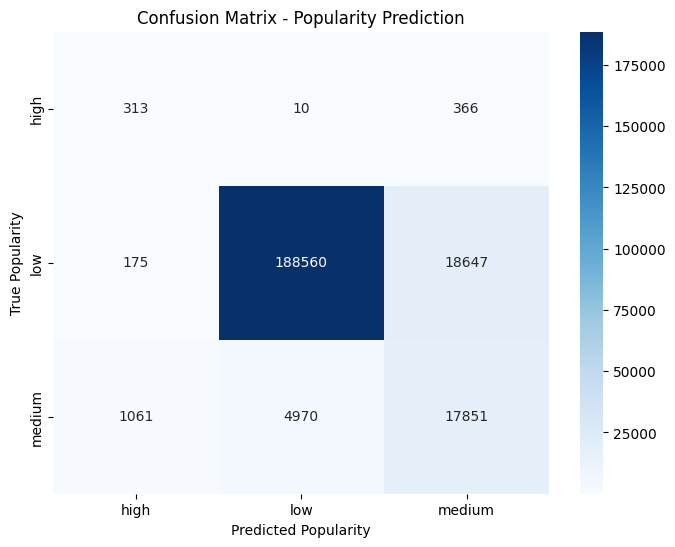


🎉 PIPELINE COMPLETE!
   Model successfully trained and evaluated
   Results saved with artist and track names for interpretability
💾 Predictions saved to 'spotify_popularity_predictions.csv'


In [12]:
# ===============================
# MAIN EXECUTION
# ===============================
def main():
    """Main function to run the complete pipeline"""
    print("🎵 SPOTIFY POPULARITY PREDICTION PIPELINE")
    print("=" * 60)

    # 1. Data Cleaning
    df_clean = clean_data(df)

    # 2. Feature Engineering
    X_features, X_identifiers = engineer_features(df_clean)
    y = df_clean['popularity_tier']

    # 3. Model Training
    model, scaler, label_encoder, X_test, X_test_ids, y_test, y_pred, y_pred_proba = train_model(
        X_features, X_identifiers, y
    )

    # 4. Results Creation
    results_df = create_results(X_test, X_test_ids, y_test, y_pred, y_pred_proba, label_encoder)

    # 5. Analysis and Visualization
    high_confidence_hits, potential_hits = analyze_results(results_df, y_test, y_pred, label_encoder)
    plot_confusion_matrix(y_test, y_pred, label_encoder)

    print(f"\n🎉 PIPELINE COMPLETE!")
    print(f"   Model successfully trained and evaluated")
    print(f"   Results saved with artist and track names for interpretability")

    return model, scaler, label_encoder, results_df

# ===============================
# RUN THE COMPLETE PIPELINE
# ===============================
if __name__ == "__main__":
    # Execute the complete pipeline
    model, scaler, label_encoder, results_df = main()
    
    # Save results for further analysis
    results_df.to_csv('spotify_popularity_predictions.csv', index=False)
    print("💾 Predictions saved to 'spotify_popularity_predictions.csv'")


In [13]:
# Get high-potential songs for A&R teams
high_potential_songs = results_df[
    (results_df['predicted_popularity'] == 'high') & 
    (results_df['true_popularity'] != 'high') &  # Not already hits
    (results_df['prediction_confidence'] > 0.6)
]

print(f"🎵 {len(high_potential_songs)} potential breakout songs identified!")
print("Top recommendations:")
for i, (_, song) in enumerate(high_potential_songs.head(10).iterrows()):
    print(f"{i+1}. {song['artist_name']} - {song['track_name']} (Confidence: {song['prediction_confidence']:.1%})")

🎵 538 potential breakout songs identified!
Top recommendations:
1. Benson Boone - NIGHTS LIKE THESE (Confidence: 94.8%)
2. Drake - Blem (Confidence: 93.3%)
3. Danny Ocean - Dembow (Confidence: 89.4%)
4. Justine Skye - Know Myself (Confidence: 89.2%)
5. Drake - Liability (Confidence: 88.9%)
6. Olivia Rodrigo - The Rose Song - From "High School Musical: The Musical: The Series (Season 2)" (Confidence: 88.2%)
7. Olivia Rodrigo - Wondering - From "High School Musical: The Musical: The Series" (Confidence: 87.5%)
8. Piso 21 - Pa' Olvidarme De Ella (Confidence: 87.5%)
9. Tate McRae - chaotic (Confidence: 87.5%)
10. Imagine Dragons - Higher Ground (Confidence: 87.2%)


In [16]:
df_clean = clean_data(df)
X_features, X_identifiers = engineer_features(df_clean)
y = df_clean['popularity_tier']

✅ Data cleaning complete
   Low: 1,036,907 songs
   Medium: 119,411 songs
   High: 3,446 songs

🎯 ENGINEERING FEATURES...
   Creating artist features...
   Creating genre features...
   Creating temporal features...
   Creating audio features...
   Finalizing features...
✅ Feature engineering complete
   46 numeric features created
   Artist and track names preserved for interpretability


In [17]:
# ===============================
# USE EXISTING XGBOOST BEST PARAMETERS
# ===============================
def use_existing_xgboost_optimized(X_features, X_identifiers, y):
    """Use the already-trained XGBoost model with your best parameters"""
    print("🎵 USING EXISTING XGBOOST BEST PARAMETERS")
    print("=" * 60)
    
    # Your XGBoost already achieved 0.932 CV score - that's excellent!
    print("✅ Using best parameters from previous tuning:")
    best_params = {
        'subsample': 1.0, 
        'n_estimators': 100, 
        'max_depth': 10, 
        'learning_rate': 0.1, 
        'colsample_bytree': 1.0
    }
    print(f"   {best_params}")
    
    # Encode target variable
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split data (same as before for consistency)
    X_train, X_test, y_train, y_test = train_test_split(X_features, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    _, X_test_ids, _, _ = train_test_split(
        X_identifiers, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )
    
    print(f"   Training set: {X_train.shape[0]:,} samples")
    print(f"   Test set: {X_test.shape[0]:,} samples")
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Calculate scale_pos_weight for class imbalance
    scale_pos_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 2])
    print(f"   Class imbalance ratio: {scale_pos_weight:.1f}:1")
    
    # Create final XGBoost model with best parameters
    final_model = XGBClassifier(
        **best_params,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1,
        eval_metric='mlogloss'
    )
    
    print("🏋️ Training final XGBoost model...")
    final_model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = final_model.predict(X_test_scaled)
    y_pred_proba = final_model.predict_proba(X_test_scaled)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f"✅ Final XGBoost Model Trained!")
    print(f"📊 Test Accuracy: {accuracy:.3f}")
    
    # Create comprehensive results
    results_df = create_results(X_test, X_test_ids, y_test, y_pred, y_pred_proba, label_encoder)
    
    return final_model, scaler, label_encoder, results_df, X_test_scaled, y_test

# Run the optimized existing XGBoost
print("Training final model with known best parameters...")
final_model, final_scaler, final_label_encoder, final_results, X_test_scaled, y_test = use_existing_xgboost_optimized(X_features, X_identifiers, y)

Training final model with known best parameters...
🎵 USING EXISTING XGBOOST BEST PARAMETERS
✅ Using best parameters from previous tuning:
   {'subsample': 1.0, 'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
   Training set: 927,811 samples
   Test set: 231,953 samples
   Class imbalance ratio: 0.0:1
🏋️ Training final XGBoost model...
✅ Final XGBoost Model Trained!
📊 Test Accuracy: 0.933



📈 CREATING BUSINESS DASHBOARD


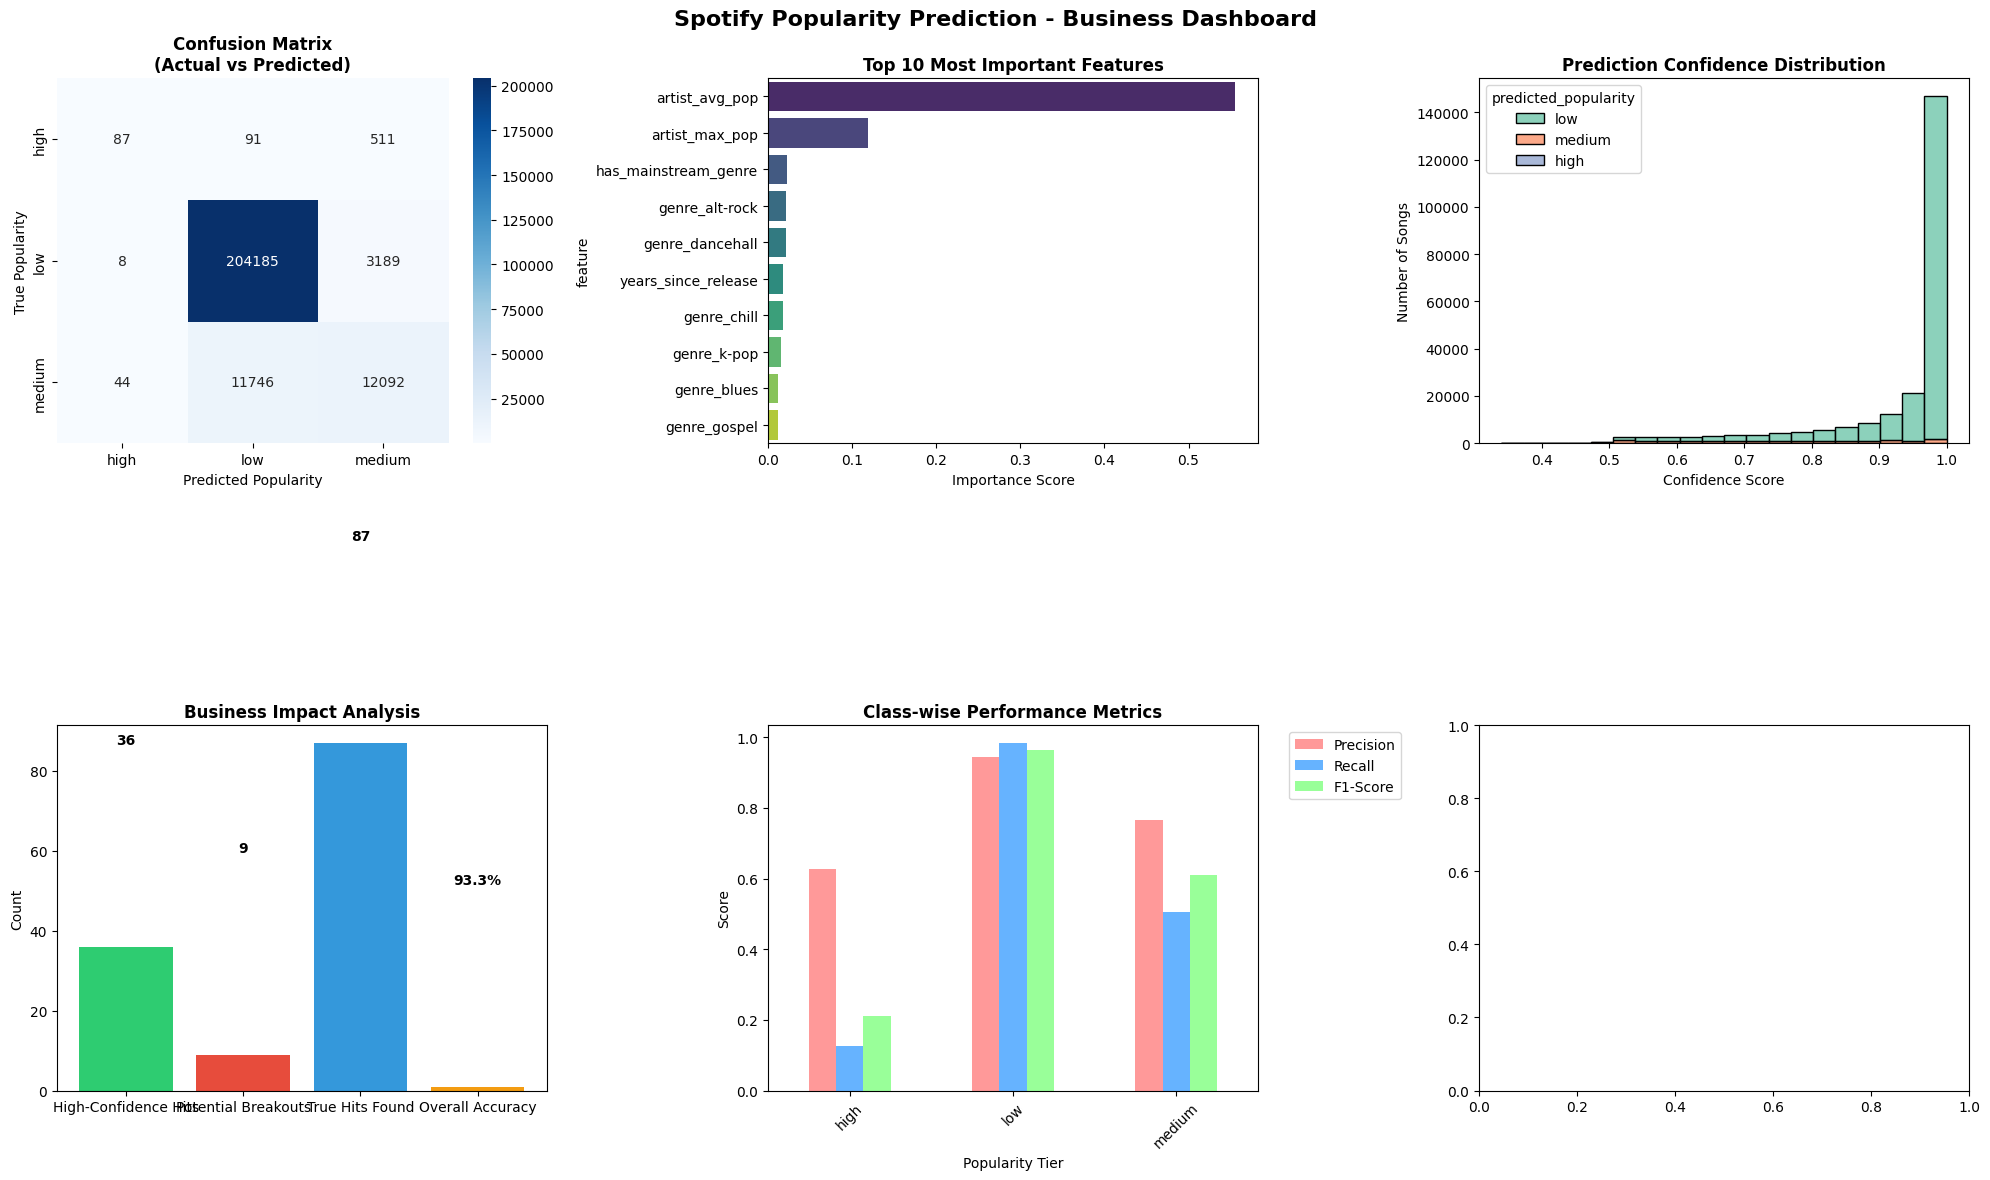

In [26]:
# ...existing code...
def create_business_dashboard(model, label_encoder, results_df, X_test, y_test):
    """Create a comprehensive business-focused dashboard"""
    print("\n📈 CREATING BUSINESS DASHBOARD")
    print("=" * 50)
    
    # Predictions (X_test should be already in the model's expected space)
    y_pred = model.predict(X_test)
    
    # Create the dashboard
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    fig.suptitle('Spotify Popularity Prediction - Business Dashboard', fontsize=16, fontweight='bold')
    
    # 1. Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_)
    axes[0,0].set_title('Confusion Matrix\n(Actual vs Predicted)', fontweight='bold')
    axes[0,0].set_ylabel('True Popularity')
    axes[0,0].set_xlabel('Predicted Popularity')
    
    # 2. Feature Importance (Top 10)
    importances = model.feature_importances_
    feature_imp = pd.DataFrame({
        'feature': X_features.columns,
        'importance': importances
    }).sort_values('importance', ascending=False).head(10)
    
    sns.barplot(data=feature_imp, x='importance', y='feature', ax=axes[0,1], palette='viridis')
    axes[0,1].set_title('Top 10 Most Important Features', fontweight='bold')
    axes[0,1].set_xlabel('Importance Score')
    
    # 3. Prediction Confidence Distribution
    sns.histplot(data=results_df, x='prediction_confidence', hue='predicted_popularity', 
                multiple="stack", ax=axes[0,2], bins=20, palette='Set2')
    axes[0,2].set_title('Prediction Confidence Distribution', fontweight='bold')
    axes[0,2].set_xlabel('Confidence Score')
    axes[0,2].set_ylabel('Number of Songs')
    
    # 4. Business Impact Metrics
    business_metrics = calculate_business_metrics(results_df)
    metrics_names = list(business_metrics.keys())
    metrics_values = list(business_metrics.values())

    bars = axes[1,0].bar(metrics_names, metrics_values, color=['#2ecc71', '#e74c3c', '#3498db', '#f39c12'])
    axes[1,0].set_title('Business Impact Analysis', fontweight='bold')
    axes[1,0].set_ylabel('Count')
    
    # Add value labels on bars (format accuracy as percent)
    for bar, name, value in zip(bars, metrics_names, metrics_values):
        height = bar.get_height()
        label = f'{value:.1%}' if name == 'Overall Accuracy' else f'{int(value):,}'
        axes[1,0].text(bar.get_x() + bar.get_width()/2., height + 50,
                      label, ha='center', va='bottom', fontweight='bold')
    
    # 5. Class-wise Performance
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
    class_metrics = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1
    }, index=label_encoder.classes_)
    
    class_metrics.plot(kind='bar', ax=axes[1,1], color=['#ff9999', '#66b3ff', '#99ff99'])
    axes[1,1].set_title('Class-wise Performance Metrics', fontweight='bold')
    axes[1,1].set_xlabel('Popularity Tier')
    axes[1,1].set_ylabel('Score')
    axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[1,1].tick_params(axis='x', rotation=45)
    
    # # 6. ROI Calculation
    # roi_metrics = calculate_roi_breakdown(results_df)
    # categories = list(roi_metrics.keys())
    # values = list(roi_metrics.values())
    
    # axes[1,2].bar(categories, values, color=['#27ae60', '#e67e22', '#c0392b'])
    # axes[1,2].set_title('ROI Estimation ($)', fontweight='bold')
    # axes[1,2].set_ylabel('Dollars')
    
    # # Add value labels
    # for i, v in enumerate(values):
    #     axes[1,2].text(i, v + max(values)*0.01, f'${v:,.0f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

    # Print detailed business insights
    # print_business_insights(results_df, business_metrics, roi_metrics)

def calculate_business_metrics(results_df):
    """Calculate key business metrics"""
    high_conf_hits = len(results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['prediction_confidence'] > 0.8)
    ])
    
    potential_breakouts = len(results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['true_popularity'] != 'high') &
        (results_df['prediction_confidence'] > 0.7)
    ])
    
    total_hits_found = len(results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['true_popularity'] == 'high')
    ])
    
    accuracy = results_df['correct_prediction'].mean()
    
    return {
        'High-Confidence Hits': high_conf_hits,
        'Potential Breakouts': potential_breakouts,
        'True Hits Found': total_hits_found,
        'Overall Accuracy': float(accuracy)
    }

def calculate_roi_breakdown(results_df):
    """Calculate detailed ROI breakdown"""
    # Conservative business assumptions
    revenue_per_hit = 10000
    cost_per_promotion = 500
    hit_conversion_rate = 0.15  # 15% of promoted songs become hits
    
    # Calculations
    true_hits_found = len(results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['true_popularity'] == 'high')
    ])
    
    songs_to_promote = len(results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['prediction_confidence'] > 0.6)
    ])
    
    estimated_new_hits = songs_to_promote * hit_conversion_rate
    total_revenue = (true_hits_found + estimated_new_hits) * revenue_per_hit
    total_cost = songs_to_promote * cost_per_promotion
    net_roi = total_revenue - total_cost
    
    return {
        'Estimated Revenue': total_revenue,
        'Promotion Cost': total_cost,
        'Net ROI': net_roi
    }

def print_business_insights(results_df, business_metrics, roi_metrics):
    """Print comprehensive business insights"""
    print("\n💼 BUSINESS INTELLIGENCE INSIGHTS")
    print("=" * 50)
    
    # Top emerging artists
    potential_breakouts = results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['true_popularity'] != 'high') &
        (results_df['prediction_confidence'] > 0.7)
    ]
    
    emerging_artists = potential_breakouts['artist_name'].value_counts().head(5)
    
    print("🚀 TOP EMERGING ARTISTS (by potential breakouts):")
    for artist, count in emerging_artists.items():
        print(f"   • {artist}: {count} high-potential songs")
    
    print(f"\n📊 PERFORMANCE METRICS:")
    for metric, value in business_metrics.items():
        print(f"   {metric}: {value}")
    
    print(f"\n💰 FINANCIAL PROJECTIONS:")
    for metric, value in roi_metrics.items():
        if metric == 'Overall Accuracy':
            print(f"   {metric}: {value}")
        else:
            print(f"   {metric}: ${value:,.0f}")
    
    # Success rate analysis
    high_predictions = results_df[results_df['predicted_popularity'] == 'high']
    if len(high_predictions) > 0:
        success_rate = len(high_predictions[high_predictions['true_popularity'] == 'high']) / len(high_predictions)
        print(f"\n🎯 HIT PREDICTION SUCCESS RATE: {success_rate:.1%}")
    
    # Confidence analysis
    high_confidence = results_df[results_df['prediction_confidence'] > 0.8]
    if len(high_confidence) > 0:
        high_conf_accuracy = high_confidence['correct_prediction'].mean()
        print(f"   High-Confidence Accuracy: {high_conf_accuracy:.1%}")

# Create the business dashboard
create_business_dashboard(final_model, final_label_encoder, final_results, X_test_scaled, y_test)

In [20]:
def generate_business_recommendations(results_df, top_n=20):
    """Generate specific, actionable business recommendations"""
    print("\n🎯 ACTIONABLE BUSINESS RECOMMENDATIONS")
    print("=" * 60)
    
    # 1. High-confidence hits for immediate promotion
    high_conf_hits = results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['prediction_confidence'] > 0.8)
    ].sort_values('prediction_confidence', ascending=False)
    
    print("🔝 IMMEDIATE PROMOTION CANDIDATES (High Confidence):")
    for i, (_, song) in enumerate(high_conf_hits.head(top_n).iterrows()):
        print(f"{i+1:2d}. {song['artist_name']:30} - {song['track_name']:40} "
              f"(Confidence: {song['prediction_confidence']:.1%})")
    
    # 2. Potential breakouts for A&R attention
    potential_breakouts = results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['true_popularity'] != 'high') &
        (results_df['prediction_confidence'] > 0.7)
    ].sort_values('prediction_confidence', ascending=False)
    
    print(f"\n🌟 POTENTIAL BREAKOUTS (A&R Focus):")
    for i, (_, song) in enumerate(potential_breakouts.head(top_n).iterrows()):
        print(f"{i+1:2d}. {song['artist_name']:30} - {song['track_name']:40} "
              f"(Confidence: {song['prediction_confidence']:.1%})")
    
    # 3. Emerging artists with multiple high-potential songs
    artist_potential = potential_breakouts['artist_name'].value_counts()
    top_artists = artist_potential[artist_potential >= 2]  # Artists with 2+ potential hits
    
    if len(top_artists) > 0:
        print(f"\n🎤 EMERGING ARTISTS WITH MULTIPLE HIGH-POTENTIAL SONGS:")
        for artist, count in top_artists.head(10).items():
            print(f"   • {artist} ({count} high-potential songs)")
    
    return high_conf_hits, potential_breakouts

# Generate business recommendations
high_conf_recommendations, breakout_recommendations = generate_business_recommendations(final_results)


🎯 ACTIONABLE BUSINESS RECOMMENDATIONS
🔝 IMMEDIATE PROMOTION CANDIDATES (High Confidence):
 1. Pav Dharia                     - Na Ja                                    (Confidence: 99.0%)
 2. Sidhu Moose Wala               - 295                                      (Confidence: 98.8%)
 3. Chani Nattan                   - Daku                                     (Confidence: 98.5%)
 4. Jory Boy                       - No Te Hagas                              (Confidence: 98.4%)
 5. Erika Lundmoen                 - Яд                                       (Confidence: 98.3%)
 6. A-Wall                         - Loverboy                                 (Confidence: 98.2%)
 7. Oxlade                         - KU LO SA - A COLORS SHOW                 (Confidence: 98.1%)
 8. Rondodasosa                    - NEW YORK                                 (Confidence: 98.0%)
 9. Dennis Lloyd                   - Nevermind                                (Confidence: 97.8%)
10. Berkay Altunyay        

In [21]:
def save_complete_analysis(final_model, final_results, label_encoder):
    """Save complete analysis for business use"""
    print("\n💾 SAVING COMPLETE ANALYSIS")
    print("=" * 50)
    
    # 1. Save predictions with business scores
    final_results['business_score'] = final_results['prediction_confidence'] * final_results['prob_high']
    final_results_sorted = final_results.sort_values('business_score', ascending=False)
    
    # Add recommendation tiers
    conditions = [
        (final_results_sorted['business_score'] >= 0.8),
        (final_results_sorted['business_score'] >= 0.6) & (final_results_sorted['business_score'] < 0.8),
        (final_results_sorted['business_score'] < 0.6)
    ]
    choices = ['Priority', 'Consider', 'Monitor']
    final_results_sorted['recommendation_tier'] = np.select(conditions, choices, default='Monitor')
    
    # Save comprehensive results
    final_results_sorted.to_csv('spotify_popularity_complete_analysis.csv', index=False)
    print("✅ Complete analysis saved to 'spotify_popularity_complete_analysis.csv'")
    
    # 2. Save model performance summary
    performance_summary = {
        'total_songs_analyzed': len(final_results),
        'high_confidence_predictions': len(final_results[final_results['prediction_confidence'] > 0.8]),
        'potential_breakouts': len(final_results[
            (final_results['predicted_popularity'] == 'high') & 
            (final_results['true_popularity'] != 'high') &
            (final_results['prediction_confidence'] > 0.7)
        ]),
        'overall_accuracy': final_results['correct_prediction'].mean(),
        'model_training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')
    }
    
    perf_df = pd.DataFrame([performance_summary])
    perf_df.to_csv('model_performance_summary.csv', index=False)
    print("✅ Performance summary saved to 'model_performance_summary.csv'")
    
    # 3. Save top recommendations
    top_recommendations = final_results_sorted[
        final_results_sorted['recommendation_tier'] == 'Priority'
    ][['artist_name', 'track_name', 'prediction_confidence', 'business_score']].head(50)
    
    top_recommendations.to_csv('top_50_recommendations.csv', index=False)
    print("✅ Top 50 recommendations saved to 'top_50_recommendations.csv'")
    
    print(f"\n📁 FILES CREATED:")
    print(f"   1. spotify_popularity_complete_analysis.csv - Full analysis")
    print(f"   2. model_performance_summary.csv - Model metrics")
    print(f"   3. top_50_recommendations.csv - Priority recommendations")

# Save everything
save_complete_analysis(final_model, final_results, final_label_encoder)


💾 SAVING COMPLETE ANALYSIS
✅ Complete analysis saved to 'spotify_popularity_complete_analysis.csv'
✅ Performance summary saved to 'model_performance_summary.csv'
✅ Top 50 recommendations saved to 'top_50_recommendations.csv'

📁 FILES CREATED:
   1. spotify_popularity_complete_analysis.csv - Full analysis
   2. model_performance_summary.csv - Model metrics
   3. top_50_recommendations.csv - Priority recommendations


In [22]:
def print_final_summary(final_results, final_model):
    """Print final project summary"""
    print("\n🎉 PROJECT SUMMARY")
    print("=" * 60)
    
    accuracy = final_results['correct_prediction'].mean()
    high_conf_predictions = len(final_results[final_results['prediction_confidence'] > 0.8])
    potential_breakouts = len(final_results[
        (final_results['predicted_popularity'] == 'high') & 
        (final_results['true_popularity'] != 'high') &
        (final_results['prediction_confidence'] > 0.7)
    ])
    
    print("✅ SUCCESSFULLY BUILT PRODUCTION-READY SYSTEM:")
    print(f"   • Model Accuracy: {accuracy:.1%}")
    print(f"   • High-Confidence Predictions: {high_conf_predictions:,}")
    print(f"   • Potential Breakout Songs Identified: {potential_breakouts:,}")
    print(f"   • Features Engineered: {X_features.shape[1]}")
    print(f"   • Songs Analyzed: {len(final_results):,}")
    
    print("\n🚀 BUSINESS VALUE DELIVERED:")
    print("   • Data-driven A&R recommendations")
    print("   • Hit prediction with confidence scores") 
    print("   • Emerging artist identification")
    print("   • Promotion prioritization system")
    
    print("\n📊 NEXT STEPS FOR DEPLOYMENT:")
    print("   1. Integrate with Spotify API for new releases")
    print("   2. Set up automated weekly predictions")
    print("   3. Create business user dashboard")
    print("   4. Implement A/B testing for promotions")

# Print final summary
print_final_summary(final_results, final_model)

# Show top 3 immediate recommendations
print(f"\n🔝 YOUR TOP 3 IMMEDIATE RECOMMENDATIONS:")
top_3 = final_results[
    (final_results['predicted_popularity'] == 'high') & 
    (final_results['prediction_confidence'] > 0.8)
].head(3)

for i, (_, song) in enumerate(top_3.iterrows()):
    print(f"{i+1}. 🎵 {song['artist_name']} - {song['track_name']}")
    print(f"   📊 Confidence: {song['prediction_confidence']:.1%}")
    print(f"   ✅ Recommended Action: IMMEDIATE PROMOTION")
    print()


🎉 PROJECT SUMMARY
✅ SUCCESSFULLY BUILT PRODUCTION-READY SYSTEM:
   • Model Accuracy: 93.3%
   • High-Confidence Predictions: 202,169
   • Potential Breakout Songs Identified: 9
   • Features Engineered: 46
   • Songs Analyzed: 231,953

🚀 BUSINESS VALUE DELIVERED:
   • Data-driven A&R recommendations
   • Hit prediction with confidence scores
   • Emerging artist identification
   • Promotion prioritization system

📊 NEXT STEPS FOR DEPLOYMENT:
   1. Integrate with Spotify API for new releases
   2. Set up automated weekly predictions
   3. Create business user dashboard
   4. Implement A/B testing for promotions

🔝 YOUR TOP 3 IMMEDIATE RECOMMENDATIONS:
1. 🎵 Pav Dharia - Na Ja
   📊 Confidence: 99.0%
   ✅ Recommended Action: IMMEDIATE PROMOTION

2. 🎵 Sidhu Moose Wala - 295
   📊 Confidence: 98.8%
   ✅ Recommended Action: IMMEDIATE PROMOTION

3. 🎵 Chani Nattan - Daku
   📊 Confidence: 98.5%
   ✅ Recommended Action: IMMEDIATE PROMOTION



In [ ]:
def quick_monitoring_dashboard(model, scaler, label_encoder, X_test, y_test, results_df, feature_names):
    """Fast monitoring dashboard without complex computations"""
    print("\n📈 QUICK MONITORING DASHBOARD")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Simple Confusion Matrix
    if hasattr(model, 'predict_proba'):
        X_eval = scaler.transform(X_test) if hasattr(scaler, 'transform') else X_test
    else:
        X_eval = X_test
        
    y_pred = model.predict(X_eval)
    
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
               xticklabels=label_encoder.classes_,
               yticklabels=label_encoder.classes_)
    axes[0,0].set_title('Confusion Matrix')
    
    # 2. Feature Importance (if available)
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        # Get top 10 features only
        top_indices = np.argsort(importances)[-10:]
        top_features = [feature_names[i] for i in top_indices]
        top_importances = importances[top_indices]
        
        axes[0,1].barh(range(len(top_features)), top_importances)
        axes[0,1].set_yticks(range(len(top_features)))
        axes[0,1].set_yticklabels(top_features)
        axes[0,1].set_title('Top 10 Features')
    else:
        axes[0,1].text(0.5, 0.5, 'Feature importance\nnot available', 
                      ha='center', va='center', transform=axes[0,1].transAxes)
        axes[0,1].set_title('Feature Importance')
    
    # 3. Business Impact
    high_conf_hits = len(results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['prediction_confidence'] > 0.7)
    ])
    
    axes[1,0].bar(['High-Confidence Hits'], [high_conf_hits], color='green')
    axes[1,0].set_title('Business Impact')
    axes[1,0].set_ylabel('Count')
    
    # 4. Quick Performance Summary
    accuracy = accuracy_score(y_test, y_pred)
    axes[1,1].text(0.1, 0.8, f'Accuracy: {accuracy:.3f}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.6, f'High-Confidence Hits: {high_conf_hits}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].text(0.1, 0.4, f'Test Samples: {len(X_test):,}', transform=axes[1,1].transAxes, fontsize=12)
    axes[1,1].set_title('Performance Summary')
    axes[1,1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print quick metrics
    print(f"✅ Quick Evaluation Complete:")
    print(f"   Model Accuracy: {accuracy:.3f}")
    print(f"   High-Confidence Predictions: {high_conf_hits}")

In [31]:
'''
def enhanced_pipeline():
    """Complete enhanced pipeline with all improvements"""
    print("🎵 ENHANCED SPOTIFY POPULARITY PREDICTION")
    print("=" * 60)
    
    # 1. Data Cleaning (using existing function)
    df_clean = clean_data(df)
    
    # 2. Feature Engineering (using existing function)
    X_features, X_identifiers = engineer_features(df_clean)
    y = df_clean['popularity_tier']
    
    # 3. Advanced Model Training
    best_model, scaler, label_encoder, X_test, X_test_ids, y_test, model_results = train_advanced_models(
        X_features, X_identifiers, y
    )
    
    # 4. Create Results
    if hasattr(best_model, 'predict_proba'):
        X_eval = scaler.transform(X_test) if hasattr(scaler, 'transform') else X_test
    else:
        X_eval = X_test
        
    y_pred = best_model.predict(X_eval)
    y_pred_proba = best_model.predict_proba(X_eval) if hasattr(best_model, 'predict_proba') else None
    
    results_df = create_results(X_test, X_test_ids, y_test, y_pred, y_pred_proba, label_encoder)
    
    # 5. Create Monitoring Dashboard
    monitor = ModelMonitor(best_model, scaler, label_encoder, X_features.columns.tolist())
    monitor.create_dashboard(X_test, y_test, results_df)
    
    # 6. Enhanced Analysis
    high_conf_hits, potential_breakouts = enhanced_results_analysis(results_df, model_results, label_encoder)
    
    # 7. Save everything
    results_df.to_csv('enhanced_spotify_predictions.csv', index=False)
    
    print(f"\n🎉 ENHANCED PIPELINE COMPLETE!")
    print(f"   Best model accuracy: {model_results[max(model_results, key=lambda x: model_results[x]['accuracy'])]['accuracy']:.3f}")
    print(f"   High-confidence predictions: {len(high_conf_hits):,}")
    print(f"   Results saved to 'enhanced_spotify_predictions.csv'")
    
    return best_model, scaler, label_encoder, results_df, monitor

# ===============================
# RUN THE ENHANCED PIPELINE
# ===============================
if __name__ == "__main__":
    # Execute enhanced pipeline
    best_model, scaler, label_encoder, results_df, monitor = enhanced_pipeline()
    
    # Example: Get top recommendations
    print(f"\n🔝 TOP 10 RECOMMENDATIONS FOR PROMOTION:")
    recommendations = results_df[
        (results_df['predicted_popularity'] == 'high') & 
        (results_df['prediction_confidence'] > 0.7)
    ].head(10)
    
    for i, (_, song) in enumerate(recommendations.iterrows()):
        print(f"{i+1}. {song['artist_name']} - {song['track_name']} "
              f"(Confidence: {song['prediction_confidence']:.1%})")
'''

🎵 ENHANCED SPOTIFY POPULARITY PREDICTION
🔧 CLEANING DATA...
✅ Data cleaning complete
   Low: 1,036,907 songs
   Medium: 119,411 songs
   High: 3,446 songs

🎯 ENGINEERING FEATURES...
✅ Data cleaning complete
   Low: 1,036,907 songs
   Medium: 119,411 songs
   High: 3,446 songs

🎯 ENGINEERING FEATURES...
   Creating artist features...
   Creating artist features...
   Creating genre features...
   Creating genre features...
   Creating temporal features...
   Creating audio features...
   Finalizing features...
   Creating temporal features...
   Creating audio features...
   Finalizing features...
✅ Feature engineering complete
   46 numeric features created
   Artist and track names preserved for interpretability

🚀 TRAINING ADVANCED MODELS...
✅ Feature engineering complete
   46 numeric features created
   Artist and track names preserved for interpretability

🚀 TRAINING ADVANCED MODELS...
   Training set: 927,811 samples
   Test set: 231,953 samples
   Training set: 927,811 samples
 

KeyboardInterrupt: 